# 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. DBA
자, 방금까지 진행했던 집값 예측하기를 이제 내가 한번 만져서 더 높은 결과를 얻어 보겠습니다. 일단 데이터를 불러와서 이전에 했던 처리를 해 준 뒤에 데이터를 더 살펴봅시다.

In [2]:
train = pd.read_csv('./housing/train.csv')
test = pd.read_csv('./housing/test.csv')

In [3]:
y = train['price']

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

In [5]:
del train['id']
del test['id']

In [6]:
y = np.log1p(y)
train['price']=np.log1p(train['price'])

여기까지 이전에 했던 전처리를 마치고 heatmap으로 각 칼럼의 연관성을 한번 조회해 보도록 하겠습니다.

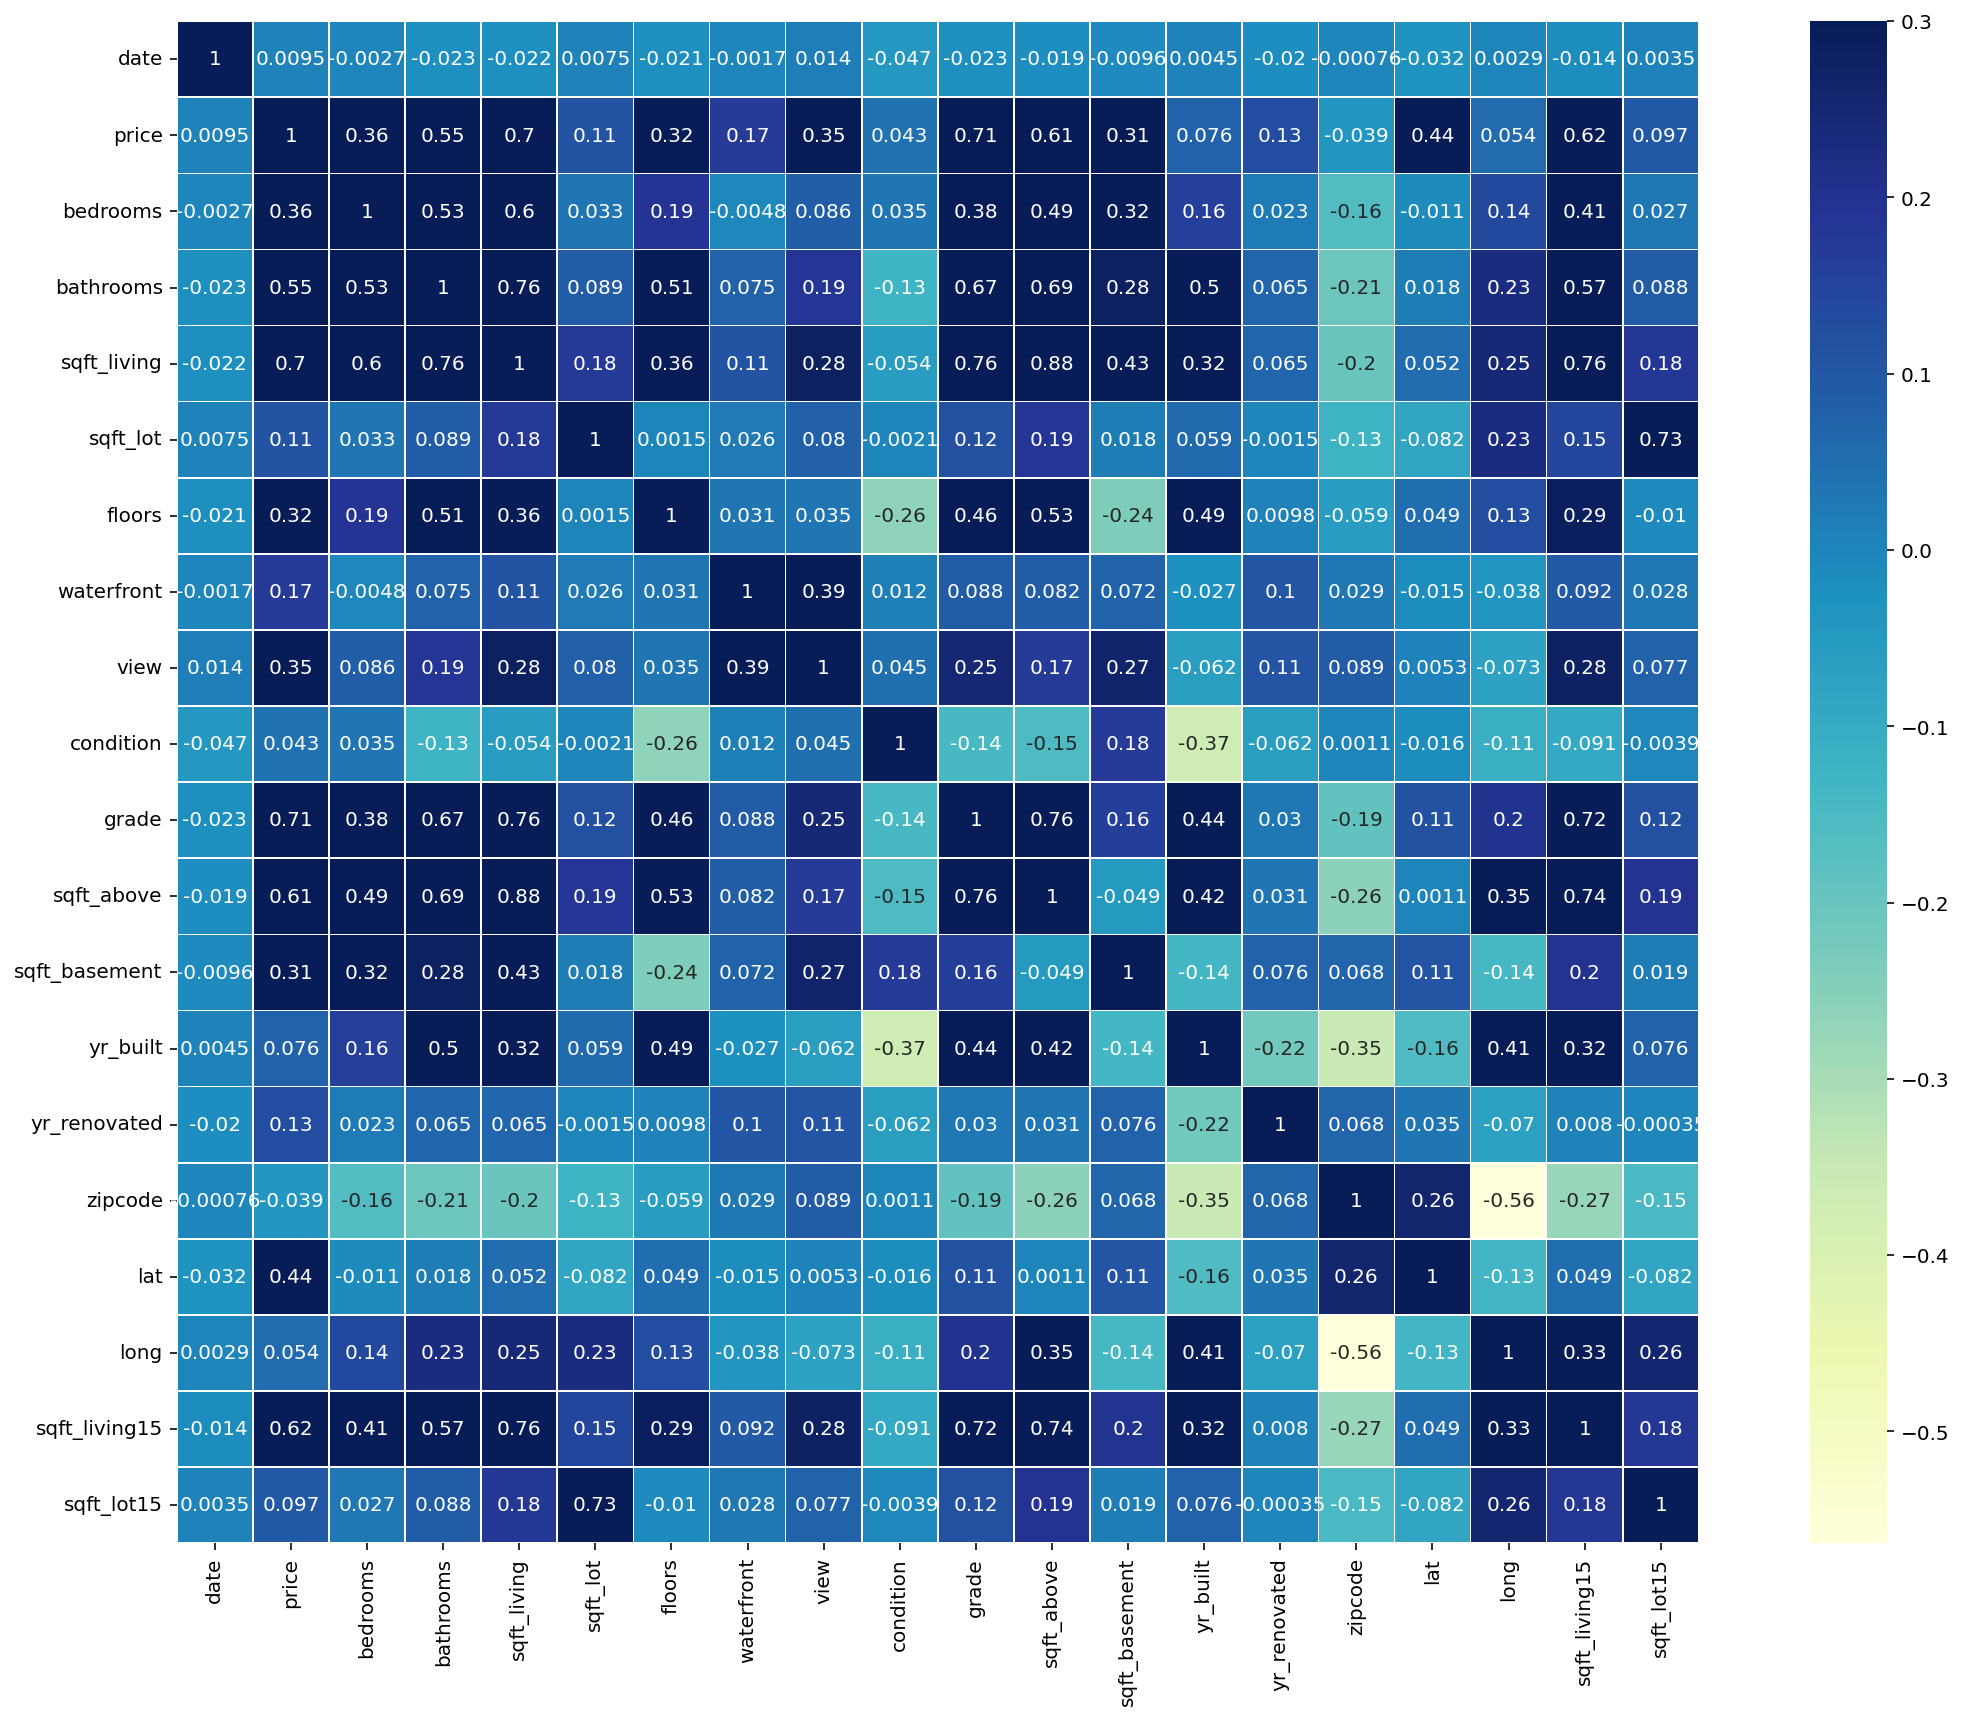

In [7]:
corr = train.corr()

f, ax = plt.subplots(figsize=(20, 14))

sns.heatmap(corr, vmax=.3, cmap='YlGnBu', square=True, linewidths=.3, annot=True)

여기서 price와 연관성이 적은 몇가지 피처를 제거해서 학습을 진행해 봤는데 점수가 더 좋지 않게 나왔습니다.  
몇가지 시도를 해보다가 피처를 가공하거나 제거하는 방법으로는 점수를 개선 시키기가 힘들 것 같아서 기존 데이터를 이용하여 새로운 칼럼을 생성해 보는 것으로 방향을 바꾸었습니다.  
우편번호나 위도, 경도를 이용해서 지역별 집값의 연관성을 찾아볼 수 있을까 하는 생각에 위도,경도별 집값을 산점도로 표현해 봤습니다.

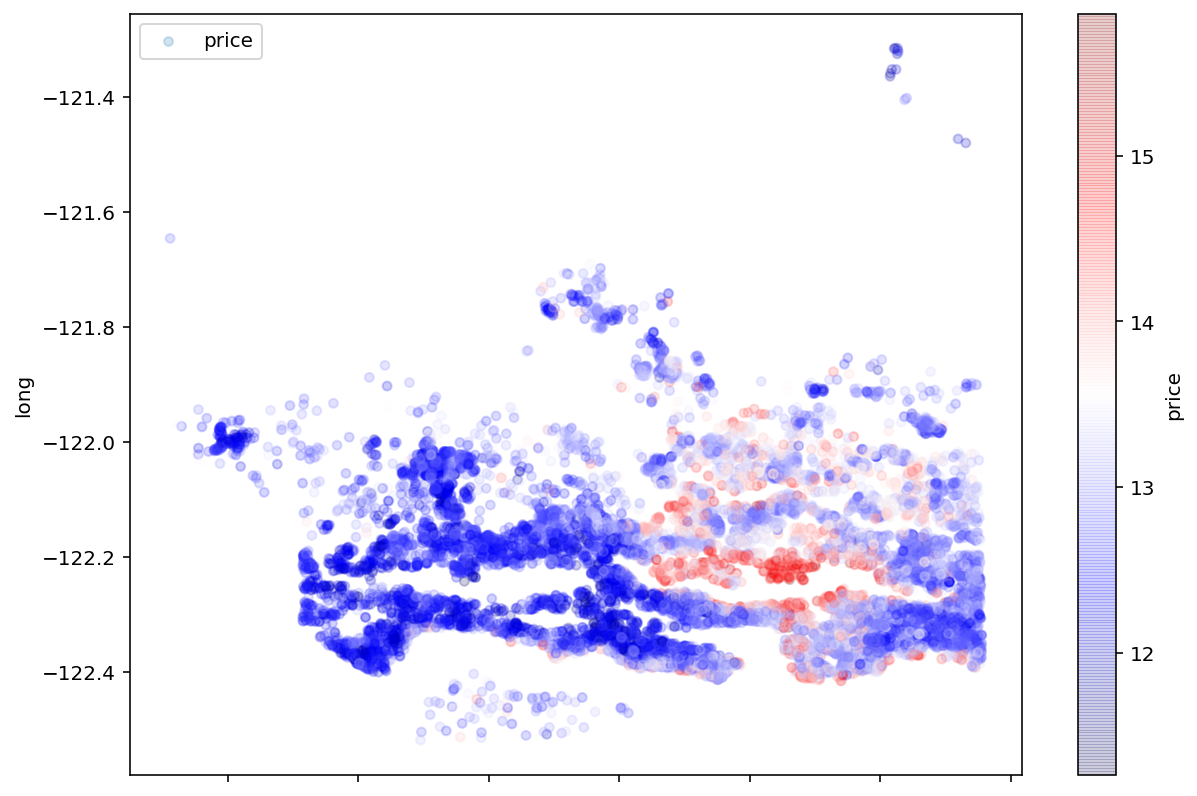

In [8]:
train.plot(kind="scatter", x="lat", y="long", alpha=0.2,
            label="price",
            c="price",
            figsize=(10,7),
            cmap=plt.get_cmap("seismic"),
            colorbar=True)
plt.legend()

높은 가격대가 형성된 지역이 있다는 것을 알 수 있습니다. 저는 경,위도를 binning한 후에 전체 지역의 지도를 11x11 모양의 배열이라고 생각하고 지역성을 나타내는 region 칼럼을 추가하도록 하겠습니다.

In [9]:
train['lat_cut'] = pd.cut(train['lat'], bins=11, labels=range(11))
train['long_cut'] = pd.cut(train['long'], bins=11, labels=range(11))

test['lat_cut'] = pd.cut(test['lat'], bins=11, labels=range(11))
test['long_cut'] = pd.cut(test['long'], bins=11, labels=range(11))

train['lat_cut'] = pd.to_numeric(train['lat_cut'])
train['long_cut'] = pd.to_numeric(train['long_cut'])

test['lat_cut'] = pd.to_numeric(test['lat_cut'])
test['long_cut'] = pd.to_numeric(test['long_cut'])

In [10]:
print(train['lat_cut'].unique())
print(train['long_cut'].unique())
print(test['lat_cut'].unique())
print(test['long_cut'].unique())

[ 6 10  8  2  4  7  9  3  5  0  1]
[ 2  4  1  3  5  7  6  0 10  9]
[ 9  6  8  3  2 10  5  4  7  0  1]
[ 1  4  3  5  2  0  6  7 10  8]


먼저 위도와 경도를 binning으로 각각 11가지로 구간화 하였습니다.

In [11]:
def categorical_region(arr, x, y):
  return arr[int(x), int(y)]

In [12]:
mark_arr = np.arange(121).reshape(11, 11)
train['region'] = train.apply(lambda row: categorical_region(mark_arr, row['lat_cut'], row['long_cut']), axis=1)
test['region'] = test.apply(lambda row: categorical_region(mark_arr, row['lat_cut'], row['long_cut']), axis=1)

그리고 0부터 시작하는 11x11배열을 만들어 구간화된 경도,위도를 이용해서 region 칼럼을 생성하였습니다. 구간화 데이터는 지워주도록 하겠습니다.  
추가적으로 아직 삭제하지 않은 타겟 데이터 칼럼도 삭제하겠습니다.

In [13]:
del train['lat_cut']
del train['long_cut']
del train['price']
del test['lat_cut']
del test['long_cut']

## 2. 모델 학습해보기
다음은 Linear Regression이 LGBMRegressor, XGBRegressor, Random Forest Regression 모델을 사용하여 학습을 진행해 볼 것입니다.  
평가 지표는 이전에 사용했던 RMSE를 그대로 사용하겠습니다.

In [14]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [15]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

random_state=2020

xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [xgboost, lightgbm, rdforest]

In [16]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

[03:02:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,127625.953710
RandomForestRegressor,125331.871077
LGBMRegressor,109427.998146


이전에 노드에서 얻어낸 결과와 비교하면 LGBM 모델의 점수가 조금 좋아졌습니다. 랜덤 포레스트도 미세하게 좋아졌지만 XGBRgressor의 경우 점수가 낮아졌습니다.

## 3. 하이퍼 파라미터 튜닝
LGBM과 XGBoost의 경우 제공하는 파라미터가 많아 커스터마이징 하기 좋다는 것이 장점 중 하나입니다. 그리드 서치를 통하여 모델의 최적 파라미터를 찾아보도록 하겠습니다.  
이번에는 랜덤 서치를 이용해서 최적 파라미터를 찾아보겠습니다.

### 3.1 LGBM 파라미터 튜닝  
LGBM은 다양한 파라미터를 조정할 수 있지만 여기서는 Learning Rate, num_iterations, max depth를 조정해 보겠습니다.

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

param_lgbm = { 'max_depth' : [40, 50],
               'num_iterations' : [1300, 1600, 1900, 2200],
               'learning_rate' : [0.01, 0.015, 0.02,]}

lgb_regressor = LGBMRegressor()

random_search_lgbm = RandomizedSearchCV(estimator=lgb_regressor,
                                        param_distributions = param_lgbm,
                                        scoring='neg_mean_squared_error',
                                        cv=5, n_iter = 10, random_state=random_state, n_jobs=-1)

In [18]:
random_search_lgbm.fit(train, y)

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.015, 0.02],
                                        'max_depth': [40, 50],
                                        'num_iterations': [1300, 1600, 1900,
                                                           2200]},
                   random_state=2020, scoring='neg_mean_squared_error')

In [19]:
print(random_search_lgbm.best_params_)
print(np.sqrt(-1 * random_search_lgbm.best_score_))

{'num_iterations': 2200, 'max_depth': 50, 'learning_rate': 0.015}
0.1604573770519496


최적의 파라미터로 학습한 결과입니다. 다른 모델도 돌려봅시다.

### 3.2 XGBoost 파라미터 튜닝
XGBoost에서는 max_detph, learning_rate, n_estimator 값을 조정해 보겠습니다.
> 파라미터 정보 https://wooono.tistory.com/97

In [20]:
param_xgb = { 'max_depth' : [4, 6, 8, 10],
               'n_estimator' : [100, 110, 130, 150],
               'learning_rate' : [0.1, 0.2, 0.05]
}

xgb_regressor = XGBRegressor()

random_search_xgb = RandomizedSearchCV(estimator=xgb_regressor,
                                       param_distributions = param_xgb,
                                       scoring='neg_mean_squared_error',
                                       cv=5, n_iter = 10, random_state=random_state, n_jobs=5)

In [21]:
random_search_xgb.fit(train, y)

[03:07:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_jobs=5,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.05],
                                        'max_depth': [4, 6, 8, 10],
                                        'n_estimator': [100, 110, 130, 150]},
                   random_state=2020, scoring='neg_mean_squared_error')

In [22]:
print(random_search_xgb.best_params_)
print(np.sqrt(-1 * random_search_xgb.best_score_))

{'n_estimator': 130, 'max_depth': 6, 'learning_rate': 0.2}
0.16441774078611862


LGBM보다는 좋지 않지만 그래도 좋은 결과가 나왔습니다.

### 3.3 랜덤 포레스트 파라미터 튜닝  
랜덤 포레스트에서는 max_features, n_estimator 두가지 파라미터만 조정을 해보겠습니다.

In [23]:
param_rdforest = { 'max_features' : [4, 6, 8, 9, 10, 11, 12],
                   'n_estimators' : [100, 130, 150, 180, 200]}

rdforest_regressor = RandomForestRegressor()

random_search_rdforest = RandomizedSearchCV(estimator=rdforest_regressor,
                                            param_distributions = param_rdforest,
                                            scoring='neg_mean_squared_error',
                                            cv=5, n_iter = 10, random_state=random_state, n_jobs=5)

In [24]:
random_search_rdforest.fit(train, y)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=5,
                   param_distributions={'max_features': [4, 6, 8, 9, 10, 11,
                                                         12],
                                        'n_estimators': [100, 130, 150, 180,
                                                         200]},
                   random_state=2020, scoring='neg_mean_squared_error')

In [25]:
print(random_search_rdforest.best_params_)
print(np.sqrt(-1 * random_search_rdforest.best_score_))

{'n_estimators': 200, 'max_features': 11}
0.17438829142324297


랜덤포레스트는 1.74입니다.  
이전에 제출했던 결과가 0.1643였으니 더 좋아진 모델은 LGBM 뿐이네요.

## 4. 블렌딩  
블렌딩은 다양한 모델의 학습결과를 종합하여 결과를 얻는 기법을 말합니다.  
최적의 파라미터를 얻은 모델들을 이용하여 Average Blending으로 결과를 한번 내보겠습니다.

In [26]:
def AveragingBlending(models,train_X, train_y, test_X):
  for m in models : 
    m['model'].fit(train_X, train_y)

  predictions = np.column_stack([m['model'].predict(test_X) for m in models])

  return np.mean(predictions, axis=1)

In [27]:
lgbm_best_param = LGBMRegressor(num_iterations=2200, max_depth=50, learning_rate=0.015)
xgb_best_param = XGBRegressor(n_estimator=130, max_depth=6, learning_rate=0.2)
rdforest_best_param = RandomForestRegressor(n_estimators=200, max_features=8)

models = [{'model':lgbm_best_param, 'name':'LightGBM'}, 
          {'model':xgb_best_param, 'name':'XGBoost'},
          {'model':rdforest_best_param, 'name':'RandomForest'}]

In [28]:
train_X, valid_X, train_y, valid_y = train_test_split(train, y, random_state=random_state, test_size=0.3)
      
y_pred = AveragingBlending(models,train_X, train_y, valid_X)

[03:12:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
def rmsle(y_true, y_pred, convertExp=True): 
    if convertExp:
        y_true = np.expm1(y_true) 
        y_pred = np.expm1(y_pred)
    
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2)) 
    return output

In [30]:
print(f'블렌딩 모델 RMSLE 값 : {rmsle(valid_y, y_pred, True):.4f}')

블렌딩 모델 RMSLE 값 : 0.1614


좋은 결과가 나오긴 했지만 LGBM보다는 좋지 않네요. LGBM의 하이퍼 파라미터 튜닝 모델을 최종 결과로 제출해 보겠습니다.

In [31]:
submission = pd.read_csv('./housing/sample_submission.csv')
pred = random_search_lgbm.best_estimator_.predict(test)
submission['price'] = np.expm1(pred)

In [32]:
submission.to_csv('./submission_lgbm_01604.csv', index=False)

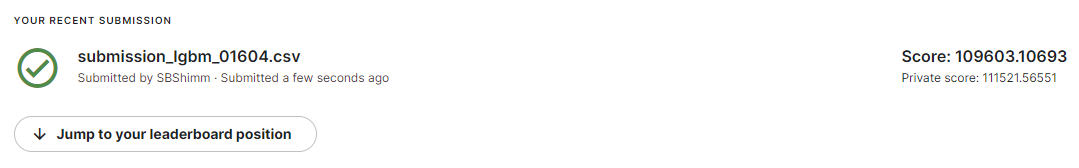

제출 결과 점수가 더 좋아졌다! 

## 5. Private score 줄이기
점수가 이전보다 좋아지긴 했지만 점수를 Private score 11만점 이하로 떨어뜨리는 걸 목표로 잡고 조정해 보기로 결정했습니다.  
https://psystat.tistory.com/131 이 사이트에서 파라미터 튜닝에 대해 알아봤는데 max_depth와 max_leaves를 조정하는 것이 Gradient Boosting 방식의 핵심이라고 합니다.  
여러번 파라미터 튜닝으로 랜덤서치를 진행하면서 LGBM과 XGB의 점수를 더욱 더 줄일 수 있었습니다.

In [33]:
param_lgbm = { 'max_depth' : [47, 48, 49],
               'num_iterations' : [2200, 2500, 2700],
               'learning_rate' : [0.018, 0.02, 0.022],
               'num_leaves' : [22, 23, 24, 25], 
               }

lgb_regressor = LGBMRegressor()

random_search_lgbm = RandomizedSearchCV(estimator=lgb_regressor,
                                        param_distributions = param_lgbm,
                                        scoring='neg_mean_squared_error',
                                        cv=5, n_iter = 10, random_state=random_state, n_jobs=-1)

param_xgb = { 'max_depth' : [9],
              'learning_rate' : [0.07, 0.085, 0.1], 
              'max_leaves' : [5, 7, 9, 11, 13]
}

xgb_regressor = XGBRegressor()

random_search_xgb = RandomizedSearchCV(estimator=xgb_regressor,
                                       param_distributions = param_xgb,
                                       scoring='neg_mean_squared_error',
                                       cv=5, n_iter = 10, random_state=random_state, n_jobs=5)

In [34]:
random_search_lgbm.fit(train, y)
print(random_search_lgbm.best_params_)
print(np.sqrt(-1 * random_search_lgbm.best_score_))

{'num_leaves': 24, 'num_iterations': 2200, 'max_depth': 48, 'learning_rate': 0.02}
0.15993766920939384


In [35]:
random_search_xgb.fit(train, y)
print(random_search_xgb.best_params_)
print(np.sqrt(-1 * random_search_xgb.best_score_))

[03:18:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_leaves': 13, 'max_depth': 9, 'learning_rate': 0.085}
0.1639327836647066


In [36]:
submission = pd.read_csv('./housing/sample_submission.csv')
pred = random_search_lgbm.best_estimator_.predict(test)
submission['price'] = np.expm1(pred)
submission.to_csv('./submission_lgbm_01599.csv', index=False)

In [37]:
submission = pd.read_csv('./housing/sample_submission.csv')
pred = random_search_xgb.best_estimator_.predict(test)
submission['price'] = np.expm1(pred)
submission.to_csv('./submission_xgb_01639.csv', index=False)

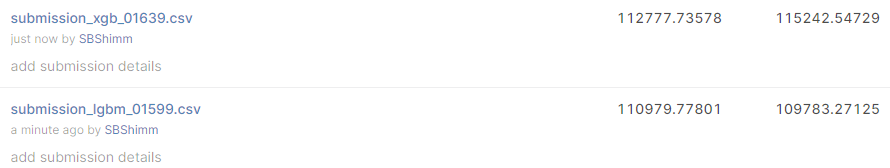

그림에서 왼쪽이 private score이고 오른쪽이 public score 입니다.  
점수가 좋아지긴 했지만 아직은 부족하네요..  
이걸 어떻게 하나 고민하다가 이전에 블렌딩을 할 때 RMSLE가 비교적 낮았던 랜덤  포레스트를 제외하고 LGBM과 XGB만 블렌딩 해서 결과를 내면 더 좋아지지 않을까 하는 생각을 하게 됬습니다.  
바로 한번 해봅시다.

In [38]:
lgbm_best_param = LGBMRegressor(num_leaves=24, num_iterations=2200, max_depth=47, learning_rate=0.02)
xgb_best_param = XGBRegressor(max_leaves=15, max_depth=9, learning_rate=0.085)

models = [{'model':lgbm_best_param, 'name':'LightGBM'}, 
          {'model':xgb_best_param, 'name':'XGBoost'}]

submission = pd.read_csv('./housing/sample_submission.csv')
y_pred = AveragingBlending(models,train, y, test)
submission['price'] = np.expm1(y_pred)    

[03:18:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [39]:
submission.to_csv('./submission_blending_1.csv', index=False)      

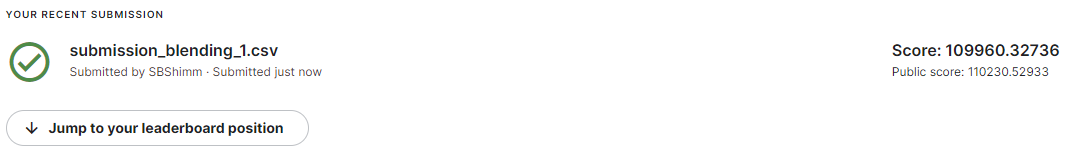

드디어.. private score가 11만점 아래로 내려갔습니다.

## 회고
- 최대한 필요 없는 피처를 줄이고 높은 점수를 뽑아보고 싶었는데 점수가 계속 내려가서 결국 원점에서 다시 시작하게 되었다. 피처를 삭제하는건 신중하게 해야할 것 같다. 
- 피처를 줄여서 점수를 뽑을 때 세 모델 모두 비슷한 점수가 나왔을 때에는 블렌딩을 했을 때 더 좋은 점수가 나왔었는데 마지막에는 랜덤 포레스트의 점수가 조금 차이가 났었어서 그런지 LGBM보단 더 안좋게 나왔다. 더 좋은 결과를 낼 수 없어서 아쉽지만.. 이만 익스4도 해야하기 때문에 점수를 더 줄이기가 힘들 것 같다.  
 -----------(5.Private score 줄이기 하기 전)-----------   
- 파라미터를 계속 바꿔가면서 점수를 줄이려고 하다보니 파일 이름이 너무 헷갈렸다. 중간에 점수가 잘 나온 모델이 있었는데 파일 이름이 헷갈려서 놓쳐버렸다. 모델마다 파일 이름을 다르게 잘 설정해서 구분을 잘 해야될 것 같다. 
- 비교적으로 점수가 낮았던 랜덤 포레스트를 제외하고 블렌딩을 하니 결국 점수를 높일 수 있었다. 상황에 따라 모델을 어떻게 관리할 지 익숙해 져야 할 것 같다.